#### Reference

[1]. Ramprasaath R. Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna Vedantam, Devi Parikh, Dhruv Batra, 

[2]. Jonas Paluci Barbosa, https://www.kaggle.com/code/jonaspalucibarbosa/chest-x-ray-pneumonia-cnn-transfer-learning/notebook, Licence: Apache 2.0, 2021.

[3]. Daniel Kermany, Kang Zhang, Michael Goldbaum, https://data.mendeley.com/datasets/rscbjbr9sj/3, Licence: CC BY 4.0, June 2018.

[4]. Christian Szegedy, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed, Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, Andrew Rabinovich, Going Deeper with Convolutions, https://arxiv.org/abs/1409.4842, Nov 2021.

In [1]:
import os
import glob
import numpy as np
import pandas as pd

In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [3]:
main_path = "./chest_xray"

train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [4]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [34]:
df_train.head()

,class,image
0,Normal,./chest_xray/train/NORMAL/NORMAL-9585882-0001....
1,Normal,./chest_xray/train/NORMAL/NORMAL-974509-0002.jpeg
2,Normal,./chest_xray/train/NORMAL/NORMAL-7953615-0001....
3,Normal,./chest_xray/train/NORMAL/NORMAL-7998429-0001....
4,Normal,./chest_xray/train/NORMAL/NORMAL-4649665-0001....


In [35]:
df_test.head()

,class,image
0,Normal,./chest_xray/test/NORMAL/NORMAL-2771774-0001.jpeg
1,Normal,./chest_xray/test/NORMAL/NORMAL-5356114-0001.jpeg
2,Normal,./chest_xray/test/NORMAL/NORMAL-3346259-0001.jpeg
3,Normal,./chest_xray/test/NORMAL/NORMAL-2578531-0001.jpeg
4,Normal,./chest_xray/test/NORMAL/NORMAL-6085151-0001.jpeg


# validationの抽出
---

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [36]:
train_df.head()

,class,image
3566,Pneumonia,./chest_xray/train/PNEUMONIA/VIRUS-5164118-000...
2866,Pneumonia,./chest_xray/train/PNEUMONIA/BACTERIA-7564600-...
2681,Pneumonia,./chest_xray/train/PNEUMONIA/VIRUS-3312900-000...
1199,Normal,./chest_xray/train/NORMAL/NORMAL-4234436-0001....
4619,Pneumonia,./chest_xray/train/PNEUMONIA/VIRUS-7654964-000...


In [37]:
val_df.head()

,class,image
2945,Pneumonia,./chest_xray/train/PNEUMONIA/VIRUS-37006-0003....
4878,Pneumonia,./chest_xray/train/PNEUMONIA/BACTERIA-8241424-...
3177,Pneumonia,./chest_xray/train/PNEUMONIA/BACTERIA-2253626-...
972,Normal,./chest_xray/train/NORMAL/NORMAL-6433176-0002....
3059,Pneumonia,./chest_xray/train/PNEUMONIA/VIRUS-6897628-000...


# データ前処理
---

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-09-27 18:14:54.045682: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)


val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


# CNN構築
---

In [ ]:
from tensorflow.keras import callbacks
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
early_stopping = callbacks.EarlyStopping(
    # 監視対象の指標は検証データセット（validation data）の損失（loss）である。
    monitor='val_loss',
    # 検証データセットの損失が改善されないエポック数が5エポック以上続いた場合にトレーニングを早期停止する。
    patience=5,
    # 損失の改善がこの閾値未満の場合に早期停止する。
    min_delta=1e-7,
    # 早期停止がトリガーされた場合、最良の重みを復元する。
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    # 学習率を減少させる際の係数。学習率はこの係数を乗じることで減少する。
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,        
    # 学習率が減少した後、新たな減少をトリガーしないようにするクールダウンエポック数である。
    cooldown = 0,
    # コールバックの動作を詳細にログに記録します。
    verbose = 1
) 

In [ ]:
def get_model():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)
    
    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [ ]:
keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')

model.summary()

In [ ]:
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

In [ ]:
model.save('Chest_XRay_model.h5')

# grad_CAMにより判断の根拠を可視化する

参照論文:  
https://arxiv.org/abs/1610.02391  

---

In [13]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow import GradientTape
import numpy as np
import matplotlib.pyplot as plt

In [14]:
model = load_model("Chest_XRay_model.h5")

2023-09-27 18:15:06.215874: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
target_layer = model.get_layer("conv2d_3")

In [16]:
intermediate_model = Model(inputs=[model.inputs], outputs=[target_layer.output, model.output])

In [17]:
print(ds_test[0][0].shape)

(1, 224, 224, 3)


## grad_CAMの計算

(1, 224, 224, 3)


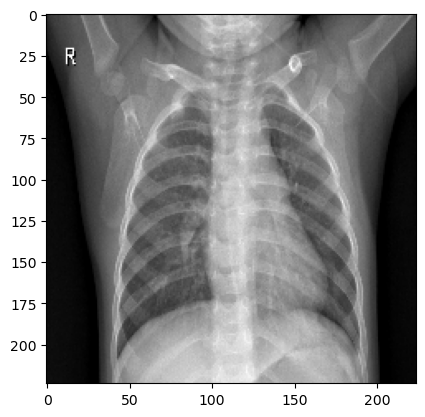

In [38]:
# 入力画像準備
idx = 100　# 入力する画像のインデックス指定
input_img = ds_test[idx][0]
print(input_img.shape)
plt.imshow(input_img[0])

In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [21]:
# Grad-CAMの計算
input_img_tensor = tf.convert_to_tensor(input_img.reshape(1, 224, 224, 3))  # NumPy配列をテンソルに変換
with tf.GradientTape() as tape:
    tape.watch(input_img_tensor)  # ここでテンソルをwatch
    conv_output, predictions = intermediate_model(input_img_tensor)
    class_idx = np.argmax(predictions[0])
    loss = predictions[:, class_idx]

<img src="./screen_shots/grad_CAM.png" align="left">
<img src="./screen_shots/relu.png" align="left">

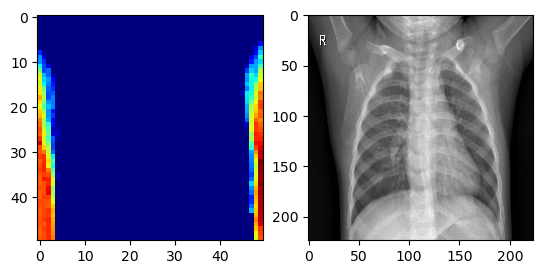

In [22]:
# 勾配を取得
# 通常の勾配の計算(誤差を重みで微分)とは異なり、grad_CAMでは、対象クラスの誤差を特徴マップで微分している。
grads = tape.gradient(loss, conv_output)[0]

# グローバル平均プーリング
# ここでのweights(重み)は、通常の機械学習の文脈における重みではなく、
# Grad-CAMの文脈で特定の特徴マップがどれだけ重要であるかを示す量。
weights = np.mean(grads, axis=(0, 1))

# Grad-CAMの計算
# conv_output[0]はバッチのindex0番目に対応している。今回は１枚のみなので[0]のみ存在している。
cam = np.dot(conv_output[0], weights)
cam = np.maximum(cam, 0)  # ReLU
cam = cam / cam.max()  # 正規化

# 可視化
plt.subplot(121)
plt.imshow(cam, cmap="jet")

plt.subplot(122)
plt.imshow(input_img[0], cmap='gray')

plt.show()

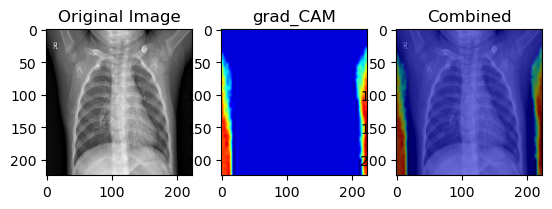

In [27]:
from scipy.ndimage import zoom

# 50x50の特徴マップを224x224にアップサンプリング
zoom_factor = 224 / 50  # 28: ターゲットのサイズ, 14: 元のサイズ
cam_resized = zoom(cam, zoom_factor)

# grad_CAMの位置を調整する。
# shift_x, shift_y = 4, 0  # ずらすピクセル数
# cam_resized = np.roll(cam_resized, shift_x, axis=0)
# cam_resized = np.roll(cam_resized, shift_y, axis=1)

# プロット
plt.subplot(131)
plt.title("Original Image")
plt.imshow(input_img[0], cmap="gray")

plt.subplot(132)
plt.title("grad_CAM")
plt.imshow(cam_resized, cmap="jet")

plt.subplot(133)
plt.title("Combined")
plt.imshow(input_img[0], cmap="gray")
plt.imshow(cam_resized, cmap='jet', alpha=0.5) 

plt.show()


背景を根拠に診断している事が判明

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

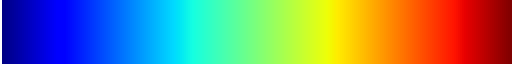

In [29]:
# カラーマップ
cmap = plt.get_cmap('jet')
cmaplist = [cmap(i) for i in range(cmap.N)]
# 0の値を無色透明にする
cmaplist[0] = (1, 1, 1, 0.0)  # (R, G, B, Alpha)
cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_cmap', cmaplist, cmap.N)
cmap_custom

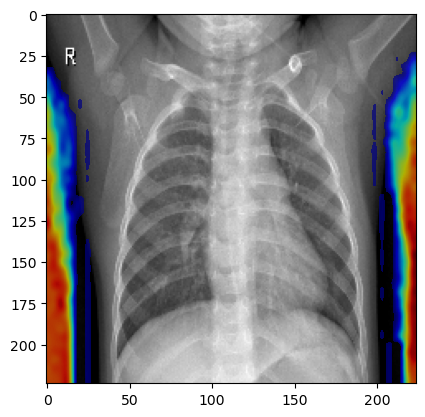

In [31]:
import matplotlib.colors as mcolors


# 元の画像
plt.imshow(input_img[0], cmap='gray')
# CAMを透過してオーバーレイ表示
plt.imshow(cam_resized, cmap=cmap_custom, alpha=0.7, vmin=0)

plt.show()

背景しか学習していなかったことがわかる。

↓以下保存用

In [ ]:
# from decimal import Decimal

# level = Decimal('0.0')
# for i in range(0, 10):
#     plt.imshow(input_img[0], cmap='gray')
#     plt.imshow(cam_resized, cmap=cmap_custom, alpha=0.7, vmin=level)
#     plt.savefig(f'./chest_cam_images/image_{int(level*10)}.png')

#     level += Decimal('0.1')